# Homework 2


## Experiment 1

### Download MNIST

In [1]:

from torchvision import transforms, datasets

train_set = datasets.MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=True)

test_set = datasets.MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=False)



### Hyperparameters

In [2]:
train_batch_size = 100
test_batch_size = 10000
epoch_num = 10
lr = 1

### Construct DataLoader

In [3]:
import torch
from torch.utils.data import DataLoader

device = torch.device('cuda')
print("Using device:", device)
print(torch.__version__)
print(torch.version.cuda)              # Should not be None
print(torch.cuda.is_available())       # Should be True if everything is correct

train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)



Using device: cuda
2.5.1
12.4
True


### Initialize the parameters
1. Weight for FC1: 784 x 100
2. Bias for FC1： 100 x 1
3. Weight for FC2: 100 x 10
4. Bias for FC2: 10 x 1

In [4]:
w_FC1 = torch.randn((784, 100), requires_grad=True, device=device)
bias_FC1 = torch.randn(100, requires_grad=True, device=device)
w_FC2 = torch.randn((100, 10), requires_grad=True, device=device)
bias_FC2 = torch.randn(10, requires_grad=True, device=device)

### Build The Network

In [6]:

losses = []
accuracies = []

for epoch in range(epoch_num):
    # Compute the test loss and accuracy in the beginning of each epoch
    test_loss_total = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for test_data, test_targets in test_loader:
            # Move the tensors to GPU
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)


            flatten_test_data = torch.flatten(test_data, start_dim=1)
            g_FC1_test = flatten_test_data @ w_FC1 + bias_FC1
            h_FC1_test = torch.maximum(g_FC1_test, torch.tensor(0.0, device=device))
            g_FC2_test = h_FC1_test @ w_FC2 + bias_FC2

            # Compute the loss
            cross_entropy_loss = torch.nn.CrossEntropyLoss()
            loss = cross_entropy_loss(g_FC2_test, test_targets)
            test_loss_total += loss.item()

            # Compute the accuracy
            predictions = torch.argmax(g_FC2_test, dim=1)
            correct_predictions += (predictions == test_targets).sum().item()
            total_samples += test_targets.size(0)

    avg_test_loss = test_loss_total / len(test_loader) # average loss for one batch
    accuracy = correct_predictions/total_samples

    print(f'Epoch {epoch + 1} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')

    losses.append(avg_test_loss)
    accuracies.append(accuracy)

    # Training
    for batch_data, batch_targets in train_loader:

        # Move the batch to GPU
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)


        # Initialize the grad
        w_FC1.grad = None
        bias_FC1.grad = None
        w_FC2.grad = None
        bias_FC2.grad = None

        # Forward Propagate
        flatten_batch_data = torch.flatten(batch_data, start_dim=1)
        g_FC1 = flatten_batch_data @ w_FC1 + bias_FC1 # Fully Connect Layer 1
        # print(g_FC1.shape)
        h_FC1 = torch.maximum(g_FC1, torch.tensor(0.0, device=device)) # ReLU 1
        g_FC2 = h_FC1 @ w_FC2 + bias_FC2 # Fully Connect Layer 2

        # Loss computing
        cross_entropy_loss = torch.nn.CrossEntropyLoss()
        input = g_FC2
        target = batch_targets
        loss = cross_entropy_loss(input, target)
        loss.backward()

        # Back Propagate
        with torch.no_grad():
                w_FC1 -= lr * w_FC1.grad
                bias_FC1 -= lr * bias_FC1.grad
                w_FC2 -= lr * w_FC2.grad
                bias_FC2 -= lr * bias_FC2.grad



Epoch 1 | Test Loss: 90.72958374023438, Test Accuracy: 0.1089
Epoch 2 | Test Loss: 0.6028609275817871, Test Accuracy: 0.8286
Epoch 3 | Test Loss: 0.5647878646850586, Test Accuracy: 0.8798
Epoch 4 | Test Loss: 0.4246300756931305, Test Accuracy: 0.8942
Epoch 5 | Test Loss: 0.3579792380332947, Test Accuracy: 0.9125
Epoch 6 | Test Loss: 0.3535684645175934, Test Accuracy: 0.9066
Epoch 7 | Test Loss: 0.3176041543483734, Test Accuracy: 0.9187
Epoch 8 | Test Loss: 0.3208352327346802, Test Accuracy: 0.9181
Epoch 9 | Test Loss: 0.28810814023017883, Test Accuracy: 0.9267
Epoch 10 | Test Loss: 0.2783640921115875, Test Accuracy: 0.9299


### Plot the graphs

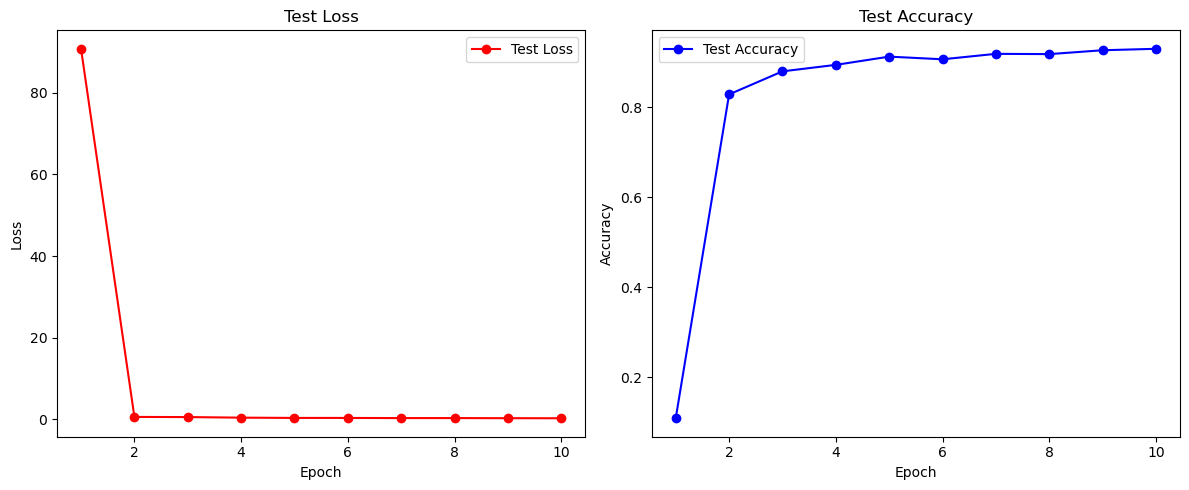

In [7]:
import matplotlib.pyplot as plt

epochs = range(1, epoch_num + 1)

plt.figure(figsize=(12, 5))

# 1) Plot the test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'r-o', label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2) Plot the test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b-o', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Some small experiments on pytorch tensors

In [29]:
# Test the broadcast
t = torch.tensor([[1, 1, 1],[2, 2, 2]])
b = torch.randn(3)
print(b)
print(t+b)



tensor([-0.5948,  1.3363, -0.8125])
tensor([[0.4052, 2.3363, 0.1875],
        [1.4052, 3.3363, 1.1875]])


## Experiment 2
10 FC layers

In [1]:
train_batch_size = 100
test_batch_size = 10000
epoch_num = 10
lr = 5e-8
num_hidden_layers = 8
seed = 100

In [2]:
from torchvision import transforms, datasets

train_set = datasets.MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=True)

test_set = datasets.MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=False)


import torch
from torch.utils.data import DataLoader

torch.manual_seed(seed)
device = torch.device('cuda')
print("Using device:", device)
print(torch.__version__)

train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)


w_FC = []
bias_FC = []

w_FC.append(torch.randn((784, 100), requires_grad=True, device=device))
bias_FC.append(torch.randn(100, requires_grad=True, device=device))

for _ in range(num_hidden_layers):
    w_FC.append(torch.randn((100, 100), requires_grad=True, device=device))
    bias_FC.append(torch.randn(100, requires_grad=True, device=device))

w_FC.append(torch.randn((100, 10), requires_grad=True, device=device))
bias_FC.append(torch.randn(10, requires_grad=True, device=device))


Using device: cuda
2.5.1


In [3]:
def nn_forward(input, weight_list, bias_list):
    g = input @ weight_list[0] + bias_list[0]
    for i in range(1, len(weight_list)):
        h = torch.maximum(g, torch.tensor(0.0, device=device))
        g = h @ weight_list[i] + bias_list[i]
    return g

In [4]:
losses = []
accuracies = []

for epoch in range(epoch_num):
    # Compute the test loss and accuracy in the beginning of each epoch
    test_loss_total = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for test_data, test_targets in test_loader:
            # Move the tensors to GPU
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            flatten_test_data = torch.flatten(test_data, start_dim=1)
            test_res = nn_forward(flatten_test_data, w_FC, bias_FC)

            # Compute the loss
            cross_entropy_loss = torch.nn.CrossEntropyLoss()
            loss = cross_entropy_loss(test_res, test_targets)
            test_loss_total += loss.item()
            print(loss.item())

            # Compute the accuracy
            predictions = torch.argmax(test_res, dim=1)
            correct_predictions += (predictions == test_targets).sum().item()
            total_samples += test_targets.size(0)

    avg_test_loss = test_loss_total / len(test_loader) # average loss for one batch
    accuracy = correct_predictions/total_samples

    print(f'Epoch {epoch + 1} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')

    losses.append(avg_test_loss)
    accuracies.append(accuracy)

    # Training
    for batch_data, batch_targets in train_loader:

        # Move the batch to GPU
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)

        # Initialize the grad
        for w in w_FC:
            w.grad = None
        for b in bias_FC:
            b.grad = None

        # Forward Propagate
        flatten_batch_data = torch.flatten(batch_data, start_dim=1)
        output = nn_forward(flatten_batch_data, w_FC, bias_FC)

        # Loss computing
        cross_entropy_loss = torch.nn.CrossEntropyLoss()
        target = batch_targets
        loss = cross_entropy_loss(output, target)
        loss.backward()

        # Back Propagate
        with torch.no_grad():
            for w in w_FC:
                w -= lr * w.grad
            for b in bias_FC:
                b -= lr * b.grad
                


566166464.0
Epoch 1 | Test Loss: 566166464.0, Test Accuracy: 0.0524
140014.28125
Epoch 2 | Test Loss: 140014.28125, Test Accuracy: 0.23
96449.4375
Epoch 3 | Test Loss: 96449.4375, Test Accuracy: 0.2341
39679.48828125
Epoch 4 | Test Loss: 39679.48828125, Test Accuracy: 0.2563
29210.5625
Epoch 5 | Test Loss: 29210.5625, Test Accuracy: 0.2466
26146.712890625
Epoch 6 | Test Loss: 26146.712890625, Test Accuracy: 0.2268
18055.314453125
Epoch 7 | Test Loss: 18055.314453125, Test Accuracy: 0.2604
15762.263671875
Epoch 8 | Test Loss: 15762.263671875, Test Accuracy: 0.2513
20376.26953125
Epoch 9 | Test Loss: 20376.26953125, Test Accuracy: 0.1936
14753.833984375
Epoch 10 | Test Loss: 14753.833984375, Test Accuracy: 0.206


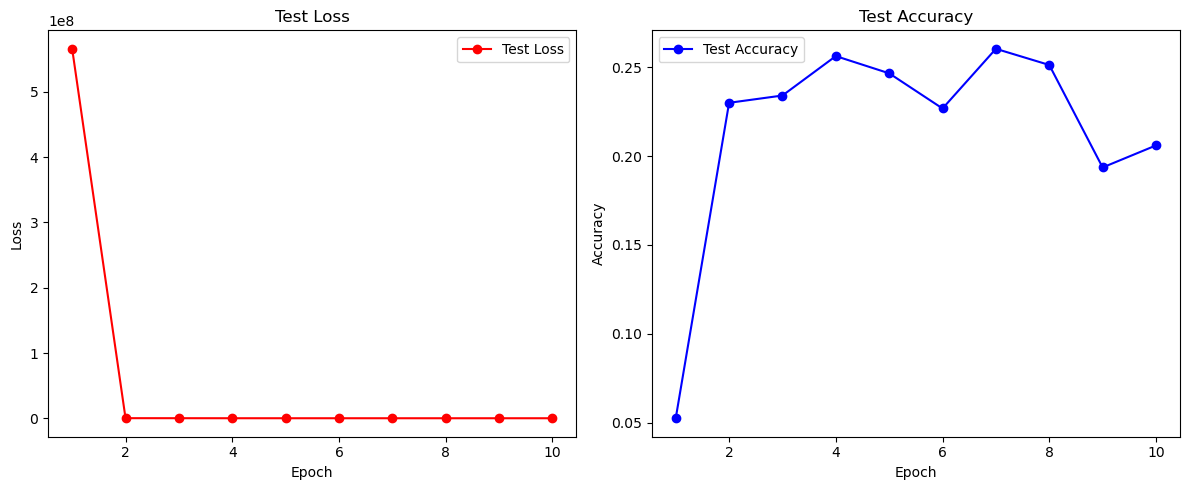

In [7]:
import matplotlib.pyplot as plt

epochs = range(1, epoch_num + 1)

plt.figure(figsize=(12, 5))

# print(losses)

# 1) Plot the test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'r-o', label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2) Plot the test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b-o', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Since it is hard to find a good learning rate for this model, apply Kaiming initialization in the next few blocks.

### Hyperparameters

In [44]:
train_batch_size = 100
test_batch_size = 10000
epoch_num = 10
lr = 0.01
num_hidden_layers = 8

In [ ]:
from torchvision import transforms, datasets

train_set = datasets.MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=True)

test_set = datasets.MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=False)


import torch
from torch.utils.data import DataLoader

device = torch.device('cuda')
print("Using device:", device)
print(torch.__version__)

train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)


w_FC = []
bias_FC = []

w_FC.append(torch.randn((784, 100), requires_grad=True, device=device))
bias_FC.append(torch.randn(100, requires_grad=True, device=device))

for _ in range(num_hidden_layers):
    w_FC.append(torch.randn((100, 100), requires_grad=True, device=device))
    bias_FC.append(torch.randn(100, requires_grad=True, device=device))

w_FC.append(torch.randn((100, 10), requires_grad=True, device=device))
bias_FC.append(torch.randn(10, requires_grad=True, device=device))


# To solve the explosion of the cross entropy loss
for w in w_FC:
    torch.nn.init.kaiming_normal_(w, a=0, nonlinearity='relu') # If not using this, the loss function will explode.
for b in bias_FC:
    b.data.fill_(0)


Using device: cuda
2.5.1


### Define a feedforward function for FC

In [46]:
# def fc_forward(input, weight, bias):
#     return input @ weight + bias

def nn_forward(input, weight_list, bias_list):
    g = input @ weight_list[0] + bias_list[0]
    for i in range(1, len(weight_list)):
        h = torch.maximum(g, torch.tensor(0.0, device=device))
        g = h @ weight_list[i] + bias_list[i]
    return g


### Training the network

In [47]:
losses = []
accuracies = []

for epoch in range(epoch_num):
    # Compute the test loss and accuracy in the beginning of each epoch
    test_loss_total = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for test_data, test_targets in test_loader:
            # Move the tensors to GPU
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            flatten_test_data = torch.flatten(test_data, start_dim=1)
            test_res = nn_forward(flatten_test_data, w_FC, bias_FC)

            # Compute the loss
            cross_entropy_loss = torch.nn.CrossEntropyLoss()
            loss = cross_entropy_loss(test_res, test_targets)
            test_loss_total += loss.item()
            # print(loss.item())

            # Compute the accuracy
            predictions = torch.argmax(test_res, dim=1)
            correct_predictions += (predictions == test_targets).sum().item()
            total_samples += test_targets.size(0)

    avg_test_loss = test_loss_total / len(test_loader) # average loss for one batch
    accuracy = correct_predictions/total_samples

    print(f'Epoch {epoch + 1} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')

    losses.append(avg_test_loss)
    accuracies.append(accuracy)

    # Training
    for batch_data, batch_targets in train_loader:

        # Move the batch to GPU
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)

        # Initialize the grad
        for w in w_FC:
            w.grad = None
        for b in bias_FC:
            b.grad = None

        # Forward Propagate
        flatten_batch_data = torch.flatten(batch_data, start_dim=1)
        output = nn_forward(flatten_batch_data, w_FC, bias_FC)

        # Loss computing
        cross_entropy_loss = torch.nn.CrossEntropyLoss()
        target = batch_targets
        loss = cross_entropy_loss(output, target)
        loss.backward()

        # Back Propagate
        with torch.no_grad():
            for w in w_FC:
                w -= lr * w.grad
            for b in bias_FC:
                b -= lr * b.grad
                

Epoch 1 | Test Loss: 7.022400856018066, Test Accuracy: 0.1149
Epoch 2 | Test Loss: 0.42187952995300293, Test Accuracy: 0.8708
Epoch 3 | Test Loss: 0.30567383766174316, Test Accuracy: 0.907
Epoch 4 | Test Loss: 0.26732566952705383, Test Accuracy: 0.9214
Epoch 5 | Test Loss: 0.22439154982566833, Test Accuracy: 0.932
Epoch 6 | Test Loss: 0.20759551227092743, Test Accuracy: 0.9364
Epoch 7 | Test Loss: 0.20153488218784332, Test Accuracy: 0.9399
Epoch 8 | Test Loss: 0.19610805809497833, Test Accuracy: 0.9421
Epoch 9 | Test Loss: 0.1800256073474884, Test Accuracy: 0.944
Epoch 10 | Test Loss: 0.17727968096733093, Test Accuracy: 0.9484


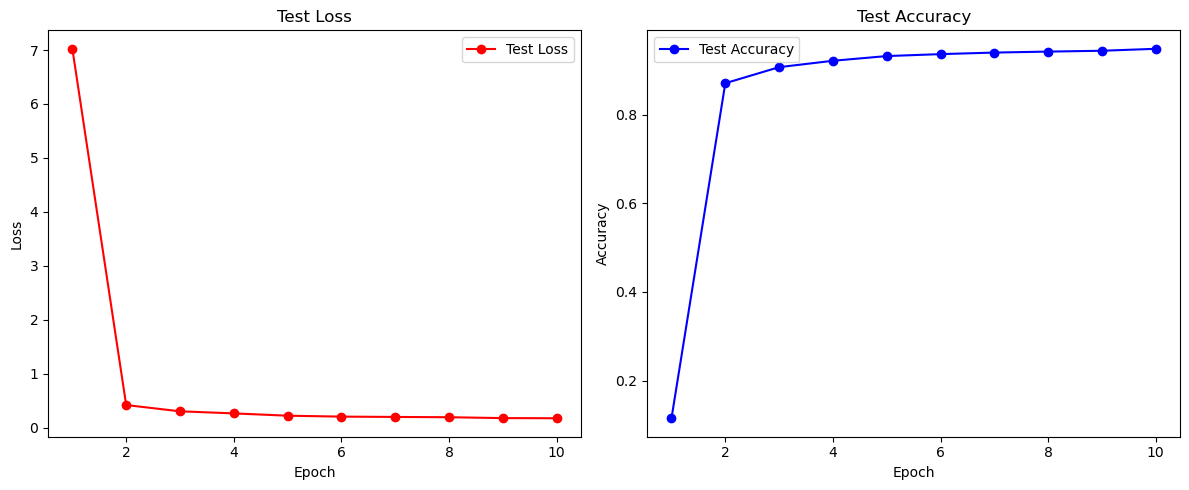

In [48]:
import matplotlib.pyplot as plt

epochs = range(1, epoch_num + 1)

plt.figure(figsize=(12, 5))

# 1) Plot the test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'r-o', label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2) Plot the test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b-o', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Experiment 3
10 FC layers + Normalization

In [50]:
train_batch_size = 100
test_batch_size = 10000
epoch_num = 10
lr = 1
num_hidden_layers = 8

In [51]:
from torchvision import transforms, datasets

train_set = datasets.MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=True)

test_set = datasets.MNIST('./', download=True,
transform=transforms.Compose([
transforms.ToTensor(),
]), train=False)


import torch
from torch.utils.data import DataLoader

device = torch.device('cuda')
print("Using device:", device)
print(torch.__version__)

train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)


w_FC = []
bias_FC = []

w_FC.append(torch.randn((784, 100), requires_grad=True, device=device))
bias_FC.append(torch.randn(100, requires_grad=True, device=device))

for _ in range(num_hidden_layers):
    w_FC.append(torch.randn((100, 100), requires_grad=True, device=device))
    bias_FC.append(torch.randn(100, requires_grad=True, device=device))

w_FC.append(torch.randn((100, 10), requires_grad=True, device=device))
bias_FC.append(torch.randn(10, requires_grad=True, device=device))


# # To solve the explosion of the cross entropy loss
# for w in w_FC:
#     torch.nn.init.kaiming_normal_(w, a=0, nonlinearity='relu') # If not using this, the loss function will explode.
# for b in bias_FC:
#     b.data.fill_(0)

Using device: cuda
2.5.1


In [52]:
def nn_forward_normalized(input, weight_list, bias_list):
    epsilon = 1e-6
    input = (input - torch.mean(input=input, dim=1, keepdim=True))/(torch.std(input=input, dim=1, keepdim=True) + epsilon)
    g = input @ weight_list[0] + bias_list[0]
    for i in range(1, len(weight_list)):
        h = torch.maximum(g, torch.tensor(0.0, device=device))
        h = (h - torch.mean(input=h, dim=1, keepdim=True))/(torch.std(input=h, dim=1, keepdim=True) + epsilon)
        g = h @ weight_list[i] + bias_list[i]
    return g

In [53]:
losses = []
accuracies = []

for epoch in range(epoch_num):
    # Compute the test loss and accuracy in the beginning of each epoch
    test_loss_total = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for test_data, test_targets in test_loader:
            # Move the tensors to GPU
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            flatten_test_data = torch.flatten(test_data, start_dim=1)
            test_res = nn_forward_normalized(flatten_test_data, w_FC, bias_FC)

            # Compute the loss
            cross_entropy_loss = torch.nn.CrossEntropyLoss()
            loss = cross_entropy_loss(test_res, test_targets)
            test_loss_total += loss.item()
            # print(loss.item())

            # Compute the accuracy
            predictions = torch.argmax(test_res, dim=1)
            correct_predictions += (predictions == test_targets).sum().item()
            total_samples += test_targets.size(0)

    avg_test_loss = test_loss_total / len(test_loader) # average loss for one batch
    accuracy = correct_predictions/total_samples

    print(f'Epoch {epoch + 1} | Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}')

    losses.append(avg_test_loss)
    accuracies.append(accuracy)

    # Training
    for batch_data, batch_targets in train_loader:

        # Move the batch to GPU
        batch_data = batch_data.to(device)
        batch_targets = batch_targets.to(device)

        # Initialize the grad
        for w in w_FC:
            w.grad = None
        for b in bias_FC:
            b.grad = None

        # Forward Propagate
        flatten_batch_data = torch.flatten(batch_data, start_dim=1)
        output = nn_forward_normalized(flatten_batch_data, w_FC, bias_FC)

        # Loss computing
        cross_entropy_loss = torch.nn.CrossEntropyLoss()
        target = batch_targets
        loss = cross_entropy_loss(output, target)
        loss.backward()

        # Back Propagate
        with torch.no_grad():
            for w in w_FC:
                w -= lr * w.grad
            for b in bias_FC:
                b -= lr * b.grad

Epoch 1 | Test Loss: 13.881567001342773, Test Accuracy: 0.1095
Epoch 2 | Test Loss: 0.3562892973423004, Test Accuracy: 0.8985
Epoch 3 | Test Loss: 0.31511634588241577, Test Accuracy: 0.9132
Epoch 4 | Test Loss: 0.21623459458351135, Test Accuracy: 0.9371
Epoch 5 | Test Loss: 0.1934605985879898, Test Accuracy: 0.946
Epoch 6 | Test Loss: 0.1830507516860962, Test Accuracy: 0.9473
Epoch 7 | Test Loss: 0.18972036242485046, Test Accuracy: 0.9506
Epoch 8 | Test Loss: 0.2066999077796936, Test Accuracy: 0.9454
Epoch 9 | Test Loss: 0.1764010190963745, Test Accuracy: 0.957
Epoch 10 | Test Loss: 0.18425193428993225, Test Accuracy: 0.9547


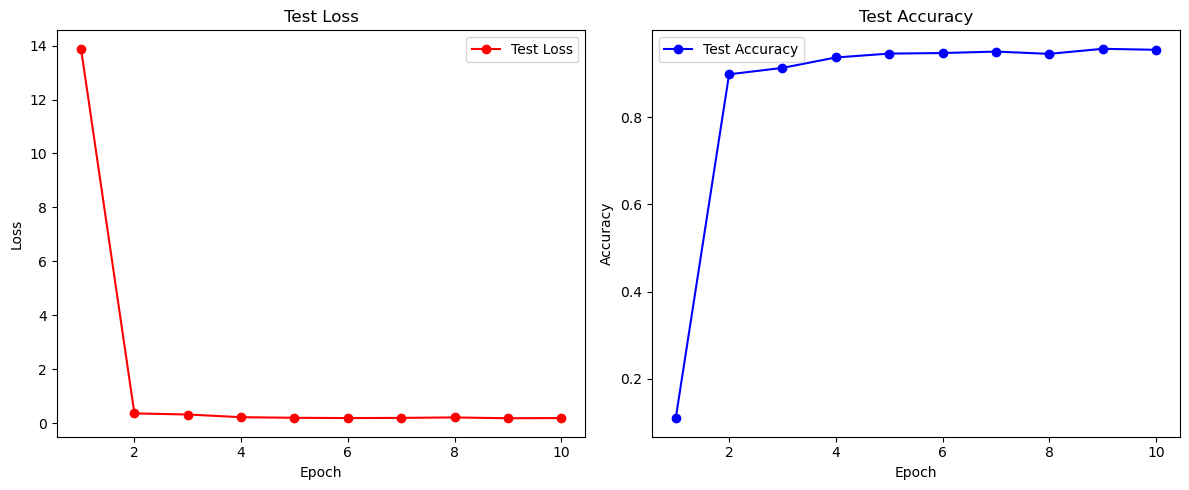

In [54]:
import matplotlib.pyplot as plt

epochs = range(1, epoch_num + 1)

plt.figure(figsize=(12, 5))

# 1) Plot the test loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'r-o', label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2) Plot the test accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, 'b-o', label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Discussion

In Experiment 1, the network structure is rather simple. Here, a very large learning rate leads to a good converge, which indicates a very small smoothness L of the loss function.

In Experiment 2, for a large learning rate, the loss function explode very quickly in one or two iteration. This might due to two possible reasons: 
1) when we have a deep network, there might be issues of gradient vanishing/exploding because of the chain rule. In this case, we may observed a gradient exploding.
2) when reduce the learning rate, it actually prevent the loss function from explosion, this might indicate a very large smoothness L to the loss function. When we have a deeper ReLU network, this will lead to a lot more piecewise linear structures in the input space. Even though the loss function is not linear, it is also structured by the same piecewise feature which is governed by the activation and de-activation of ReLU functions. This may create a very unsmooth landscape to the loss function.

After applying Kaming Initialization, the issue we observed in Experiment 2 disappeared. I am personally very interested in the reason, which I so far don't have a conclusion and I will spend some time investigate on what Kaiming Initialization contribute to the landscape of the loss function.

In Experiment 3, after applying the layer normalization, the issue we observed in Experiment 2 disappeared. This is reasonable since layer norm is a very common approach to deal with gradient exploding/vanishing. 



